# Zach Barrett

## Housing Price Prediction:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

---

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

---

In [3]:
# importing the data

train_df = pd.read_csv('train.csv', index_col='Id')

print("\nNumber of samples:", train_df.shape[0], "and number of features:", train_df.shape[1],"\n")

train_df.head()


Number of samples: 1460 and number of features: 80 



,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# printing all features

print('Num features: ', len(list(train_df.columns)))
print()
print('Features: ', list(train_df.columns))

Num features:  80

Features:  ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorc

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64



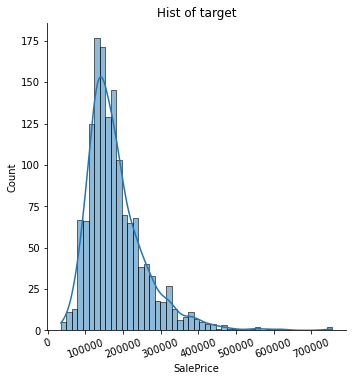

In [5]:
# analyzing the target (SalePrice)

print(train_df['SalePrice'].describe())
print()

sns.displot(train_df['SalePrice'], kde=True)
plt.title('Hist of target')
plt.xticks(rotation=20)

plt.show()

## Feature Engineering:

In [7]:
# creating total square footage feature
def createTotSF(df):
    # GrLivArea: Above grade (ground) living area square feet
    # TotalBsmtSF: Total square feet of basement area

    df['TotSF'] = df['GrLivArea'] + df['TotalBsmtSF']

In [8]:
# creating total bathroom var
def createTotBathrooms(df):
    # BsmtFullBath: Basement full bathrooms
    # BsmtHalfBath: Basement half bathrooms
    # FullBath: Full bathrooms above grade
    # HalfBath: Half baths above grade

    df['TotBathrooms'] = df['BsmtFullBath'] + df['BsmtHalfBath'] * .5 + df['FullBath'] + df['HalfBath'] * .5

In [9]:
# creating bool to see if house is remodeled
def createWasRemodeled(df):
    # YearBuilt: Original construction date
    # YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

    df['WasRemodeled'] = np.where(df['YearRemodAdd'] == df['YearBuilt'], 0, 1)

In [10]:
# creating var to see if house is new
def createIsNew(df):
    # YearBuilt: Original construction date
    # YrSold: Year Sold (YYYY)

    df['IsNew'] = np.where(df['YrSold'] == df['YearBuilt'], 1, 0)

In [11]:
# creating var to see time since updated
def createTimeSinceRemodeled(df):
    # YrSold: Year Sold (YYYY)
    # YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

    df['TimeSinceRemodeled'] = df['YrSold'] - df['YearRemodAdd']

In [12]:
# wrapper function to build all features
def featureEngineering(df):
    # using helper methods to create various features
    createTotSF(df)
    createTotBathrooms(df)
    createWasRemodeled(df)
    createIsNew(df)
    createTimeSinceRemodeled(df)

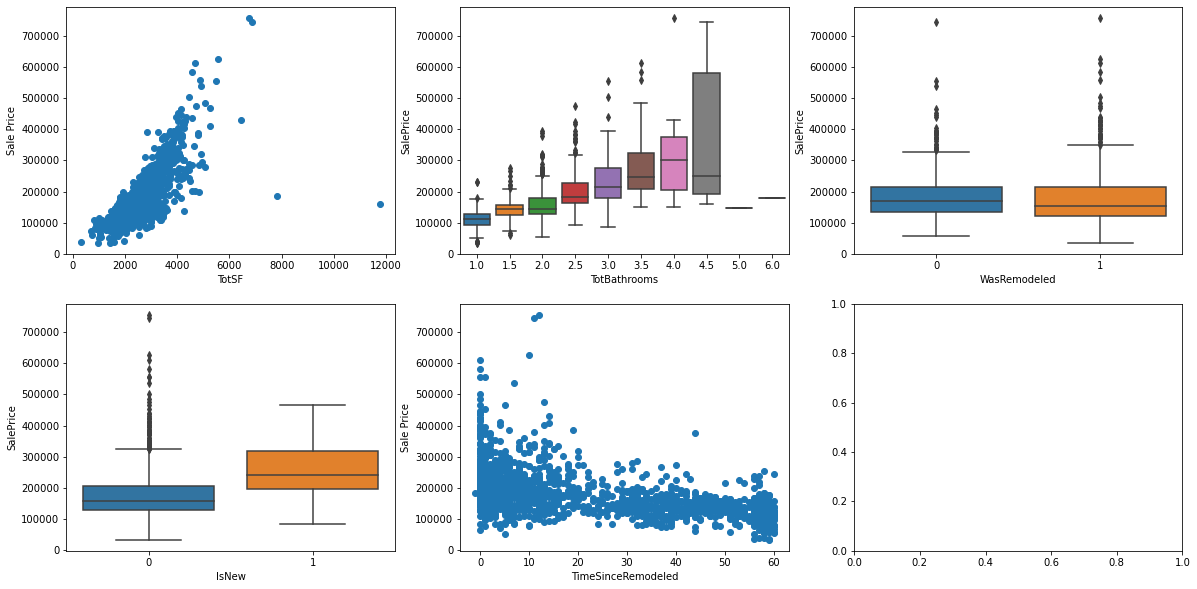

In [29]:
# visualizing these new features

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))

axes[0,0].scatter(train_df['TotSF'], train_df['SalePrice'])
axes[0,0].set_xlabel('TotSF')
axes[0,0].set_ylabel('Sale Price')

sns.boxplot(data=train_df, x="TotBathrooms", y="SalePrice", ax=axes[0,1])

sns.boxplot(data=train_df, x="WasRemodeled", y="SalePrice", ax=axes[0,2])

sns.boxplot(data=train_df, x="IsNew", y="SalePrice", ax=axes[1,0])

axes[1,1].scatter(train_df['TimeSinceRemodeled'], train_df['SalePrice'])
axes[1,1].set_xlabel('TimeSinceRemodeled')
axes[1,1].set_ylabel('Sale Price')


plt.savefig('engineered_features.png')
plt.show()

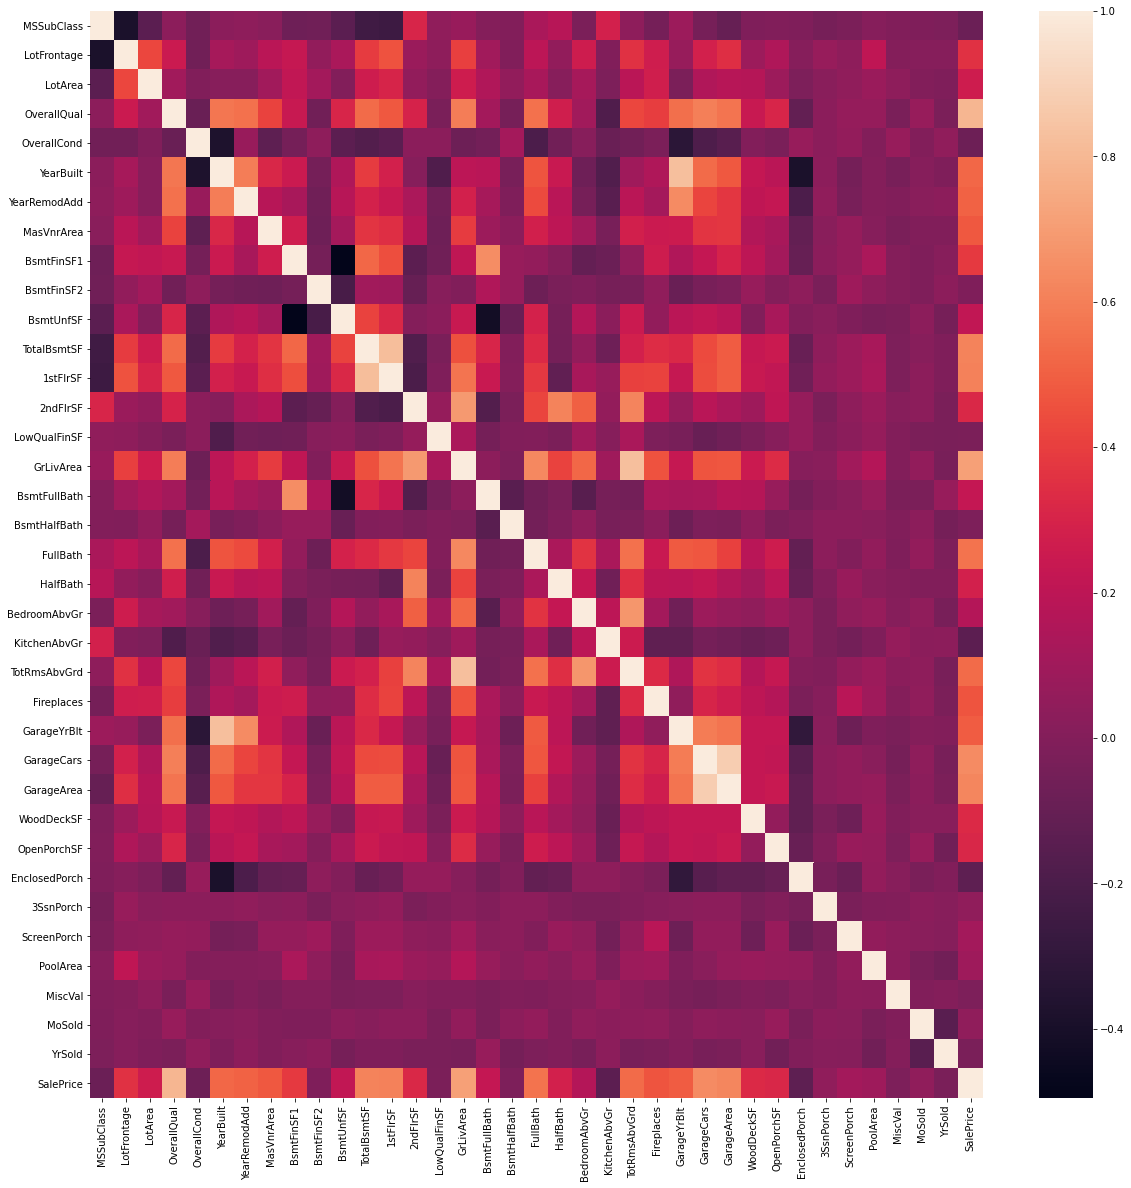

In [13]:
# visualizing correlation between features
plt.figure(figsize=(20,20)) 
sns.heatmap(train_df.corr())
plt.savefig('full_correlations.png')
plt.show(block=False)

We see there are some variables with high correlation (such as GarageCars & GarageArea). In addition to this, we can see the correlation between SalePrice and the other variables, which is helpful to understand what features might be important at a glance. From the looks of the correlations, it seems that OverallQual is very impactful, as are some of the variables pertaining to the square footage. We also can see the variable we just created is very correlated to SalePrice.

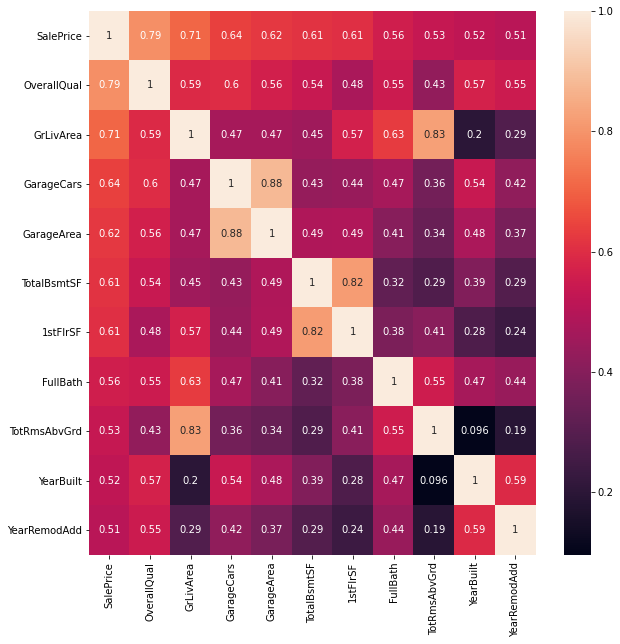

In [14]:
# Visualizing most impactful features for saleprice

corr = train_df.corr()
cols = corr.nlargest(11, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)

plt.figure(figsize=(10,10)) 
sns.heatmap(cm, annot=True, yticklabels=cols.values, xticklabels=cols.values)
plt.savefig('important_correlations.png')


plt.show()

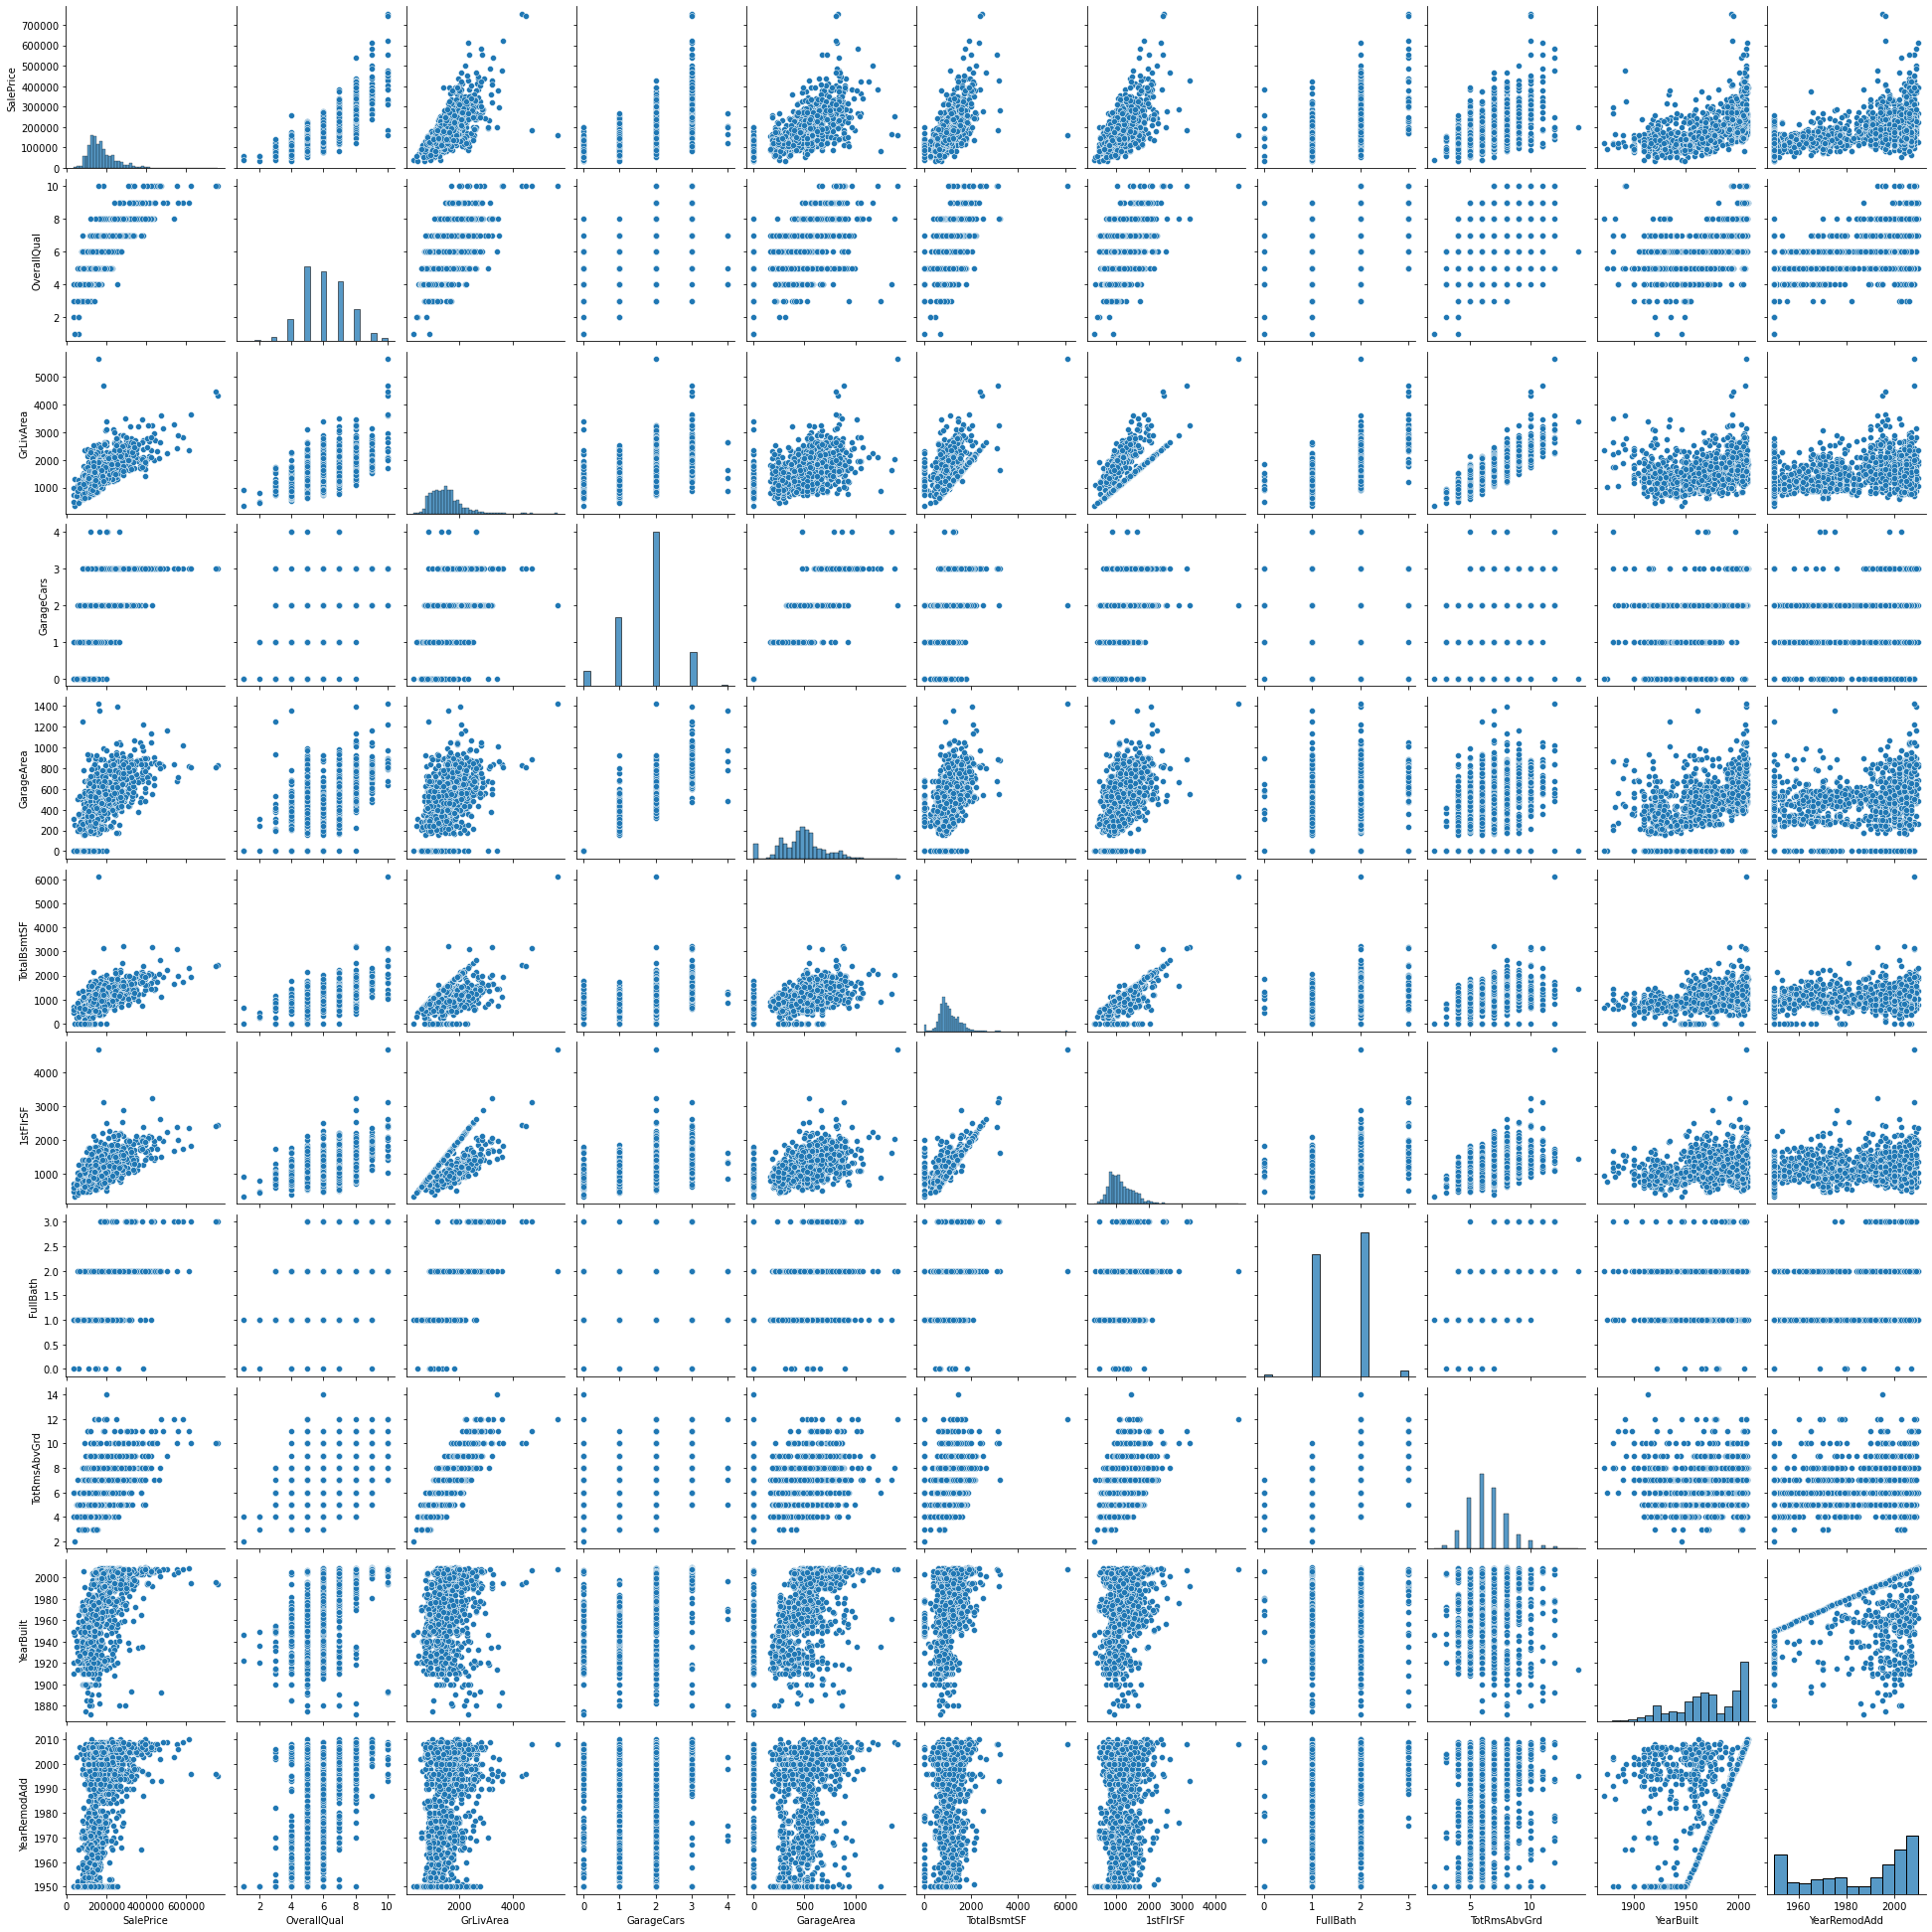

In [15]:
# looking at distributions of these highly correlated features

sns.pairplot(train_df[cols])
plt.savefig('pair_plot.png')

plt.show()

In [16]:
# finding cols with missing data

na_dict = dict(train_df.isna().any())

cols_with_missing_data = []
for feature in na_dict.keys():
    if na_dict[feature]:
        cols_with_missing_data.append(feature)

In [17]:
missing_na_sums = dict(train_df.isna().sum())

for i in cols_with_missing_data:
    print(i, ': ', missing_na_sums[i])

LotFrontage :  259
Alley :  1369
MasVnrType :  8
MasVnrArea :  8
BsmtQual :  37
BsmtCond :  37
BsmtExposure :  38
BsmtFinType1 :  37
BsmtFinType2 :  38
Electrical :  1
FireplaceQu :  690
GarageType :  81
GarageYrBlt :  81
GarageFinish :  81
GarageQual :  81
GarageCond :  81
PoolQC :  1453
Fence :  1179
MiscFeature :  1406


In [13]:
# converting categorical data into numerical representation

categorical_dict = {"KitchenQual":     {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
                "BsmtQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, np.nan: 0},
                "ExterQual":     {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
                "HeatingQC":     {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
                "LotShape": {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1},
                "LotFrontage": {np.nan: 0},
                "LandSlope": {'Gtl': 3, 'Mod': 2, 'Sev': 1},
                "ExterCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
                "BsmtExposure": {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, np.nan: 0},
                "BsmtFinType1": {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, np.nan: 0},
                "BsmtFinType2": {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, np.nan: 0},
                "CentralAir": {"Y": 1, "N": 0},
                "Functional": {"Typ": 7, "Min1": 6, "Min2": 5, "Mod": 4, "Maj1": 3, "Maj2": 2, "Sev": 1, "Sal": 0},
                "FireplaceQu": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, np.nan: 0},
                "GarageFinish": {"Fin": 3, "RFn": 2, "Unf": 1, np.nan: 0},               
                "GarageQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, np.nan: 0},
                "GarageCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, np.nan: 0},
                "PavedDrive": {"Y": 2, "P": 1, "N": 0},
                "PoolQC": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, np.nan: 0},                    
                "Alley": {"Pave": 2, "Grvl": 1, np.nan: 0},
                "MasVnrType": {np.nan: 0},
                "MasVnrArea": {np.nan: 0},
                "GarageType": {np.nan: 0},
                "MiscFeature": {np.nan: 0},
                "Fence": {np.nan: 0},
                "BsmtCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, np.nan: 0},                
               }


In [14]:
# method to work with categorical features
def handleCategoricalData(df):
    # this uses the dict with the manual replacements
    df.replace(categorical_dict, inplace=True)
    
    # this handles dummies
    df = pd.get_dummies(df, drop_first=True)
    
    return df
    

In [15]:
# calling the methods used for preprocessing & formatting data appropriately
def preprocessing(df):
    featureEngineering(df)
    df = handleCategoricalData(df)
    
    return df

In [16]:
# utilizing preprocessing method on training
train_df = preprocessing(train_df)

# using preprocessing method on test set
test_df = pd.read_csv('test.csv', index_col='Id')
test_df = preprocessing(test_df)

print('train_df shape: ', train_df.shape)
print('test_df shape: ', test_df.shape)

train_df shape:  (1460, 211)
test_df shape:  (1459, 194)


In [17]:
# adding cols that don't appear in test set

missing_cols = []
for col in list(train_df.columns):
    if col not in list(test_df.columns):
        if col != "SalePrice":
            missing_cols.append(col)
            
print(missing_cols)

for col in missing_cols:
    test_df[col] = 0

['Utilities_NoSeWa', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_2.5Fin', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_Other', 'Heating_GasA', 'Heating_OthW', 'Electrical_Mix', 'MiscFeature_TenC']


In [18]:
# ensuring that both dataframes have same ordering
y_train = np.array(train_df['SalePrice'])
train_df.drop('SalePrice', axis=1, inplace=True)

test_df = test_df[list(train_df.columns)]

# separating independent vars & target
X_train = train_df.to_numpy()
X_test = test_df.to_numpy()

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)


X_train shape:  (1460, 210)
y_train shape:  (1460,)
X_test shape:  (1459, 210)


## Modelling:

In [19]:
# building hyperparam list for random search -- not all of these will be tested, but will help with grid search

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgb = XGBRegressor(criterion='mse')

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [33]:
# saving results of random search

filename = 'random_search_xgb.pkl'

# exporting
# outfile = open(filename,'wb')
# pickle.dump(xgb_random, outfile)
# outfile.close()

# importing
# infile = open(filename,'rb')
# xgb_random = pickle.load(infile)


[15:05:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [20]:
# building best model

xgb = XGBRegressor(criterion='mse', n_estimators=2000, min_samples_split=2, min_samples_leaf=2,
                   max_features='sqrt', max_depth=20, bootstrap=True)

In [21]:
xgb.fit(X_train,y_train)

[18:04:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(bootstrap=True, criterion='mse', max_depth=20, max_features='sqrt',
             min_samples_leaf=2, min_samples_split=2, n_estimators=2000)

In [59]:
y_pred = xgb.predict(X_test)

In [60]:
# adding predictions to df

# add the prediction column

output = pd.read_csv('test.csv')
output['SalePrice'] = y_pred


# save the predicted price as a csv with a header column and ID row
output = output[['Id', 'SalePrice']].to_csv('my_prediction.csv', 
    index=False, header=True)

print("Prediction complete. Saved as my_prediction.csv")

Prediction complete. Saved as my_prediction.csv
